In [ ]:
'''
1. Fashion-MNISTデータセットの用意
'''
from tensorflow import keras
import numpy as np

#  Fashion-MNISTをダウンロード
(X_train, y_train), \
    (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
# 訓練データのピクセル値を255で割って0.0～1.0の範囲に正規化
X_train = X_train.astype(np.float32) / 255

# 訓練用画像のサイズを出力
print(X_train.shape)

(60000, 28, 28)


In [ ]:
'''
2. 生成器
'''
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

# ノイズの次元数
noise_num = 100

# 生成器
generator = keras.models.Sequential([
    # 全結合層: (bs, 100)->(bs, 6272)
    keras.layers.Dense(7 * 7 * 128, input_shape=[noise_num]),
    # テンソルの形状を変換: (bs, 6272)->(bs, 7, 7, 128)
    keras.layers.Reshape([7, 7, 128]),
    # 出力値を正規化する: (bs, 7, 7, 128)
    keras.layers.BatchNormalization(),

    # 転置畳み込み層1: (bs, 7, 7, 128)->(bs, 14, 14, 64)
    keras.layers.Conv2DTranspose(
        64,                # フィルター数64
        kernel_size=5,     # フィルターサイズ5×5
        strides=2,         # ストライド2
        padding='same',    #入力と同じ高さ/幅の次元になるようにパディング
        activation="selu"),# SELU関数を適用
    # 出力値を正規化する: (bs, 14, 14, 64)
    keras.layers.BatchNormalization(),
    
    # 転置畳み込み層2: (bs, 14, 14, 64)->(bs, 28, 28, 1)
    keras.layers.Conv2DTranspose(
        1,                 # フィルター数1
        kernel_size=5,     # フィルターサイズ5×5
        strides=2,         # ストライド2
        padding='same',    #入力と同じ高さ/幅の次元になるようにパディング
        activation="tanh") # Tanh関数を適用
])
# サマリを出力
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 840,705
Trainable params: 840,321
Non-trainable params: 384
________________________________________________

In [ ]:
'''
3. 識別器
'''
discriminator = keras.models.Sequential([
    # 畳み込み層1: (bs, 28, 28, 1)->(bs, 14, 14, 64)
    keras.layers.Conv2D(
        64,                       # フィルター数64
        kernel_size=5,            # フィルターサイズ5×5
        strides=2,                # ストライド2
        padding='same',           #入力と同じ高さ/幅の次元になるようにパディング
        activation=keras.layers.LeakyReLU(0.2), # LeakyReLU関数を適用
                                                # 論文に従って負の勾配を制御する
                                                # 係数は0.2(デフォルトは0.01)
        input_shape=[28, 28, 1]), # 入力するテンソルの形状
    
    # 40%のドロップアウト: (bs, 14, 14, 64)
    keras.layers.Dropout(0.4),

    # 畳み込み層2: (bs, 14, 14, 64)->(bs, 7, 7, 128)
    keras.layers.Conv2D(
        128,            # フィルター数128
        kernel_size=5,  # フィルターサイズ5×5
        strides=2,      # ストライド2
        padding='same', #入力と同じ高さ/幅の次元になるようにパディング
        activation=keras.layers.LeakyReLU(0.2)), # LeakyReLU関数を適用

    # 40%のドロップアウト
    keras.layers.Dropout(0.4),
    # テンソルをフラット化: (bs, 6272)
    keras.layers.Flatten(),

    # 全結合層: (bs, 6272)->(bs, 1)
    keras.layers.Dense(
        1,                    # ユニット数1
        activation="sigmoid") # シグモイド関数を適用
])
# サマリを出力
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
________________________________________________

In [ ]:
'''
4. DCGANのモデルを作成
'''
gan = keras.models.Sequential([generator, discriminator])
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28, 1)         840705    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,053,570
Trainable params: 1,053,186
Non-trainable params: 384
_________________________________________________________________


In [ ]:
'''
5. 識別器とDCGANのモデルのコンパイル
'''
# 識別器のみ単独で学習を行うのでコンパイルしておく
discriminator.compile(
    loss="binary_crossentropy", # バイナリクロスエントロピー誤差
    optimizer="rmsprop")        # オプティマイザーはRMSprop
# 識別器単独の学習モードをオフにする
discriminator.trainable = False

# DCGANのモデルをコンパイル
gan.compile(loss="binary_crossentropy", # バイナリクロスエントロピー誤差
            optimizer="rmsprop")        # オプティマイザーはRMSprop

In [ ]:
'''
6. 学習中の生成画像を描画する関数
'''
import matplotlib.pyplot as plt
%matplotlib inline

def plot_multiple_images(images, n_cols=None):
    '''
    Parameters:
      images: 生成器によって生成された画像
      n_cols: 描画領域の列数
    '''
    # 描画領域の列数を取得
    n_cols = n_cols or len(images)
    # 描画領域の行数を取得
    n_rows = (len(images) - 1) // n_cols + 1
    # 生成画像の最後の次元が1の場合は削除する
    # (bs, 28, 28, 1) -> (bs, 28, 28)
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    # 描画エリアを設定
    plt.figure(figsize=(n_cols, n_rows))
    # 画像を出力
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [ ]:
'''
7. 学習を実行する関数
'''
def train_gan(gan, dataset, batch_size, noise_num, n_epochs):
    '''学習を実行

    Parameters:
      gan: DCGANのモデル
      dataset: 訓練データ(bs, 28, 28, 1)
      batch_size: ミニバッチのサイズ
      noise_num: ノイズの次元数
      n_epochs: 学習回数
    '''
    # DCGANのモデルから生成器と識別器のネットワークを抽出
    generator, discriminator = gan.layers
    # 学習のループ(エポック)
    for epoch in range(n_epochs):
        # 現在のエポック数を出力
        print("Epoch {}/{}".format(epoch + 1, n_epochs))

        # バッチデータのループ(ステップ)
        for X_batch in dataset:
            # -----識別器の学習-----
            # 標準正規分布からノイズをバッチサイズの数だけ生成: (bs, 100)
            noise = tf.random.normal(shape=[batch_size, noise_num])
            # 生成器にノイズを入力してフェイク画像を出力: (bs, 28, 28, 1)
            generated_images = generator(noise)
            # フェイク画像とオリジナル画像を0の次元で結合
            # (bs, 28, 28, 1), (bs, 28, 28, 1) -> (bs×2, 28, 28, 1)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            # フェイク画像の正解ラベル0、オリジナル画像の正解ラベル1を
            # それぞれバッチデータの数だけ生成: 出力(bs×2, 1)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            # 識別器を学習モードにする
            discriminator.trainable = True
            # 識別器にフェイク画像とオリジナル画像のセット(bs×2, 28, 28, 1)、
            # 正解ラベル(bs×2, 1)を入力して、フェイク画像を0、
            # オリジナル画像を1に分類できるように学習する
            discriminator.train_on_batch(X_fake_and_real, y1)

            # -----生成器の学習-----
            # 標準正規分布からノイズをバッチサイズの数だけ生成: (bs, 100)
            noise = tf.random.normal(shape=[batch_size, noise_num])
            # フェイク画像の正解ラベル1(本物)をバッチデータの数だけ生成
            # (bs, 1)
            y2 = tf.constant([[1.]] * batch_size)
            # 識別器の学習は行わない
            discriminator.trainable = False
            # DCGANのモデルにフェイク画像と正解ラベル(1)を入力し、
            # フェイク画像を本物(1)と判定するように生成器のみ学習を行う
            gan.train_on_batch(noise, y2)
        
        # 1エポック終了ごとにフェイク画像を出力
        plot_multiple_images(generated_images,
                             10 # 1行に10枚ずつ出力
                             )
        plt.show()

In [ ]:
%%time
'''
8. 学習を実行
'''
batch_size = 40
n_epochs = 50

# 訓練データの構造を変換: (60000, 28, 28)->(60000, 28, 28, 1)
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1.
# 訓練データをスライスしてイテレート可能なデータセットを作成
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
# データセットから1000個単位でランダムにサンプリング
dataset = dataset.shuffle(1000)
# すべてのデータを網羅するミニバッチを作成
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

# 学習を実行
train_gan(gan,               # DCGANのモデル
          dataset,           # ミニバッチ単位のデータ
          batch_size,        # ミニバッチのサイズ
          noise_num,         # ノイズの次元数(100)
          n_epochs=n_epochs) # 学習回数

Output hidden; open in https://colab.research.google.com to view.

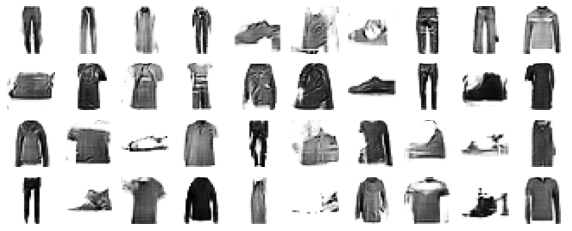

In [ ]:
'''
10. ノイズを生成器に入力して画像を生成
'''
tf.random.set_seed(123)
np.random.seed(123)

noise = tf.random.normal(shape=[batch_size, noise_num])
generated_images = generator(noise)
plot_multiple_images(generated_images, 10)